## JAI SAI RAM ##

### Import Libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression,Ridge,Lasso

<h2 align="center" style="color:blue">Data Loading</h2>

In [2]:
df=pd.read_excel("premiums_rest.xlsx")
df.head(3)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164


In [3]:
# add artificial genetical_risk column to be consistent with young model
df['Genetical_Risk'] = 0

In [4]:
df.shape

(29904, 14)

#### Make column name uniform

In [5]:
df.columns=df.columns.str.replace(" ","-").str.lower()

In [6]:
df.columns

Index(['age', 'gender', 'region', 'marital_status', 'number-of-dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical-history', 'insurance_plan',
       'annual_premium_amount', 'genetical_risk'],
      dtype='object')

In [7]:
df.columns=df.columns.str.replace("-","_").str.lower()

In [8]:
df.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount', 'genetical_risk'],
      dtype='object')

In [9]:
df.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,0


<h2 align="center" style="color:blue"> Exploratory Data Analysis & Data Cleaning</h2>

In [10]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           9
employment_status        1
income_level             9
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [11]:
df.smoking_status.unique()

array(['No Smoking', 'Regular', 'Occasional', nan, 'Does Not Smoke',
       'Not Smoking', 'Smoking=0'], dtype=object)

In [12]:
df.smoking_status.mode()

0    No Smoking
Name: smoking_status, dtype: object

In [13]:
df.income_level.unique()

array(['<10L', '10L - 25L', '> 40L', '25L - 40L', nan], dtype=object)

#### As smoking_status colud be high impacting feature and counts are only 11  compare to total count so deleting those na records instaed replacing 

In [14]:
df.dropna(inplace=True)

In [15]:
df.shape

(29886, 14)

#### Handel Duplicate Values

In [16]:
df.drop_duplicates(inplace=True)

In [17]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [18]:
df.duplicated().sum()

0

In [19]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,29886.000000,29886.000000,29886.000000,29886.000000,29886.0
mean,43.396105,2.379910,23.364184,20892.303821,0.0
std,13.412657,1.431201,24.740339,6936.813440,0.0
min,26.000000,-3.000000,1.000000,3625.000000,0.0
25%,34.000000,1.000000,7.000000,15697.250000,0.0
50%,42.000000,3.000000,17.000000,20489.000000,0.0
75%,52.000000,3.000000,32.000000,26360.000000,0.0
max,356.000000,5.000000,930.000000,43471.000000,0.0


#### Handel number_of_dependants 

In [20]:
df.number_of_dependants.unique()

array([ 0,  2,  3,  4,  1,  5, -1, -3], dtype=int64)

There are -ve values for the column which seems error and can be replced with +ve values

In [21]:
df['number_of_dependants']=df['number_of_dependants'].abs()

In [22]:
df.number_of_dependants.unique()

array([0, 2, 3, 4, 1, 5], dtype=int64)

## 1.Numeric Columns

### Univariat Analysis Numeric Columns

#### Box Plot  For Numeric Columns

In [23]:
print(df.dtypes)

age                       int64
gender                   object
region                   object
marital_status           object
number_of_dependants      int64
bmi_category             object
smoking_status           object
employment_status        object
income_level             object
income_lakhs              int64
medical_history          object
insurance_plan           object
annual_premium_amount     int64
genetical_risk            int64
dtype: object


In [24]:
numeric_coluns=df.select_dtypes(include=['int64']).columns
numeric_coluns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount',
       'genetical_risk'],
      dtype='object')

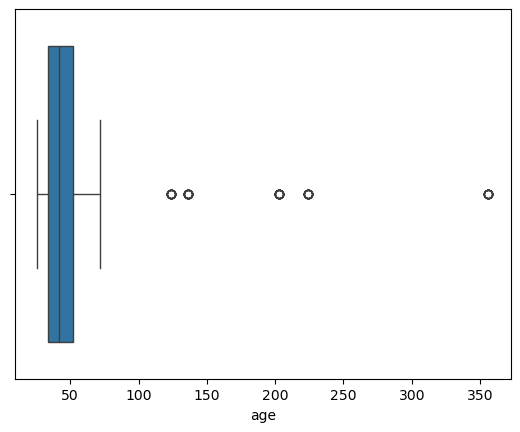

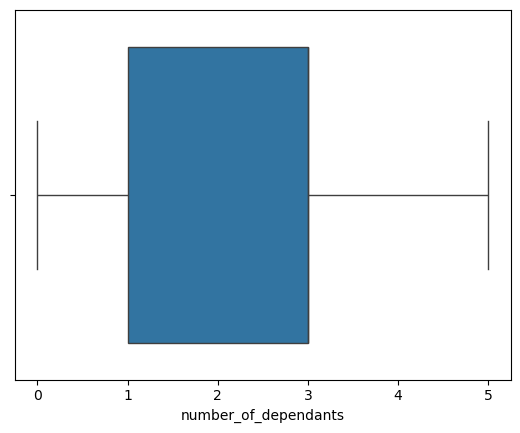

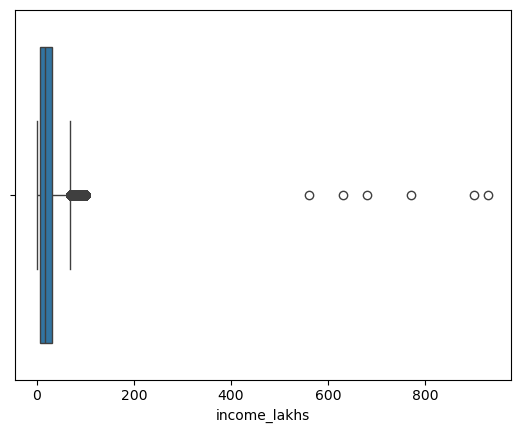

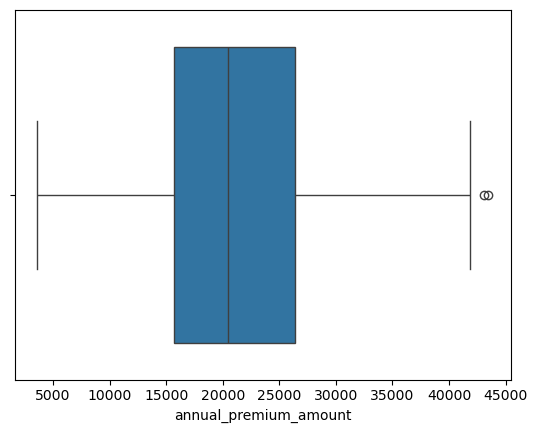

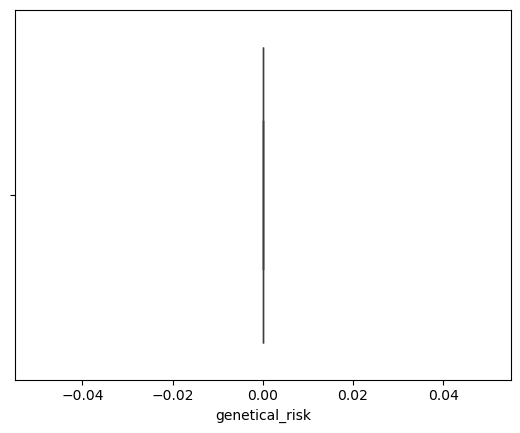

In [25]:
for col in numeric_coluns:
    sns.boxplot(x=df[col])
    plt.show()

#### Outlier Tratment to Age Column

In [26]:
df[df['age']>100]['age'].unique()

array([224, 124, 136, 203, 356], dtype=int64)

In [27]:
df_OT=df[df['age']<=100]

In [28]:
df_OT[df_OT['age']>100]

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk


In [29]:
df_OT.shape

(29828, 14)

In [30]:
df_OT.age.describe()

count    29828.000000
mean        43.095380
std         11.041991
min         26.000000
25%         34.000000
50%         42.000000
75%         52.000000
max         72.000000
Name: age, dtype: float64

#### Outlier Treatment Income Column

In [31]:
def get_iqr_bounds(col):
    Q1,Q3=col.quantile([0.25,0.75])
    IQR=Q3-Q1
    lower_bound=Q1-1.5*IQR
    upper_bound=Q3+1.5*IQR
    return lower_bound,upper_bound

lower,upper=get_iqr_bounds(df_OT['income_lakhs'])
lower,upper

(-30.5, 69.5)

In [32]:
df_OT[df['income_lakhs']>upper].shape

C:\Users\kalpe\AppData\Local\Temp\ipykernel_11388\882339787.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_OT[df['income_lakhs']>upper].shape


(2090, 14)

There are many legitimate records that we will get rid of if we use IQR bounds method. Hence after discussion with business we decided to use a simple quantile bound 

In [33]:
quantile_threshold=df_OT['income_lakhs'].quantile(0.999)
quantile_threshold

100.0

In [34]:
df_OT[df_OT['income_lakhs']>quantile_threshold].shape

(6, 14)

In [35]:
df_OT1=df_OT[df_OT['income_lakhs']<=quantile_threshold].copy()
df_OT1.shape

(29822, 14)

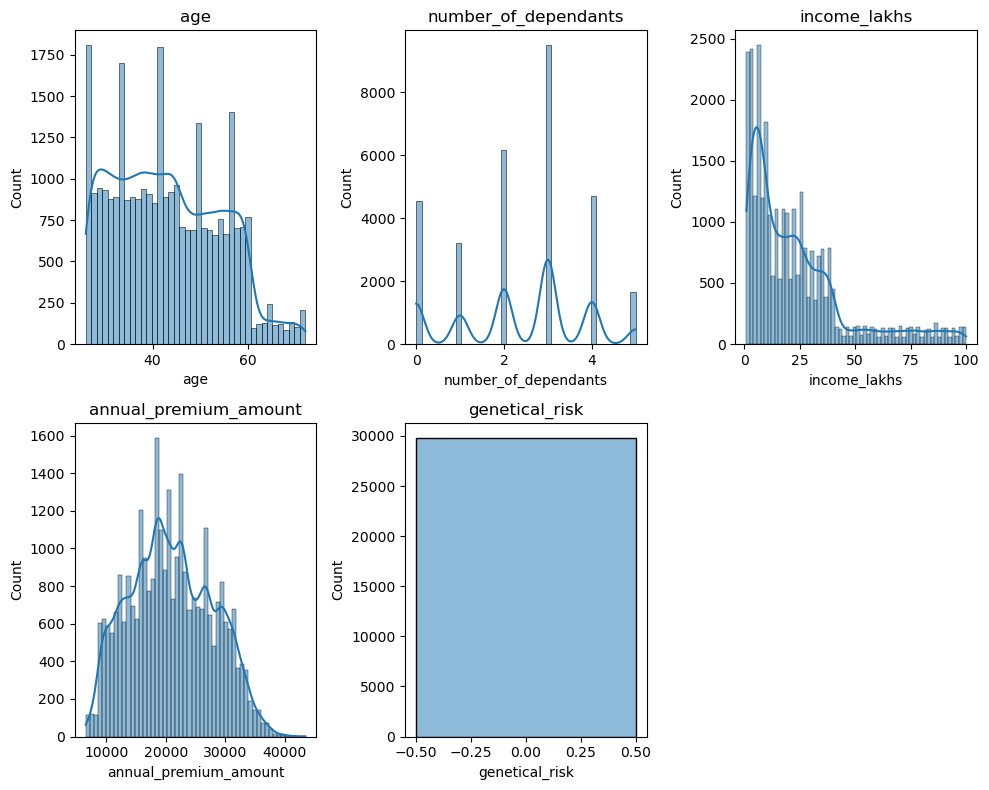

In [36]:
figs,axs=plt.subplots(nrows=2,ncols=3,figsize=(10,8))
for i,columns in enumerate(numeric_coluns):
    ax=axs[i//3,i%3]  # Determines the position of the subplot in the grid
    sns.histplot(df_OT1[columns],kde=True,ax=ax)
    ax.set_title(columns)

# If the last subplot axis is unused, you can turn it off
if len(numeric_coluns) % 3 != 0:
    for j in range(len(numeric_coluns), 6):  # This will disable any unused subplots
        axs.flat[j].set_visible(False)    
    
plt.tight_layout()
plt.show()

In [37]:
df_OT1.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0


### Bivariant Analysis :Numeric Columns

In [38]:
numeric_coluns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount',
       'genetical_risk'],
      dtype='object')

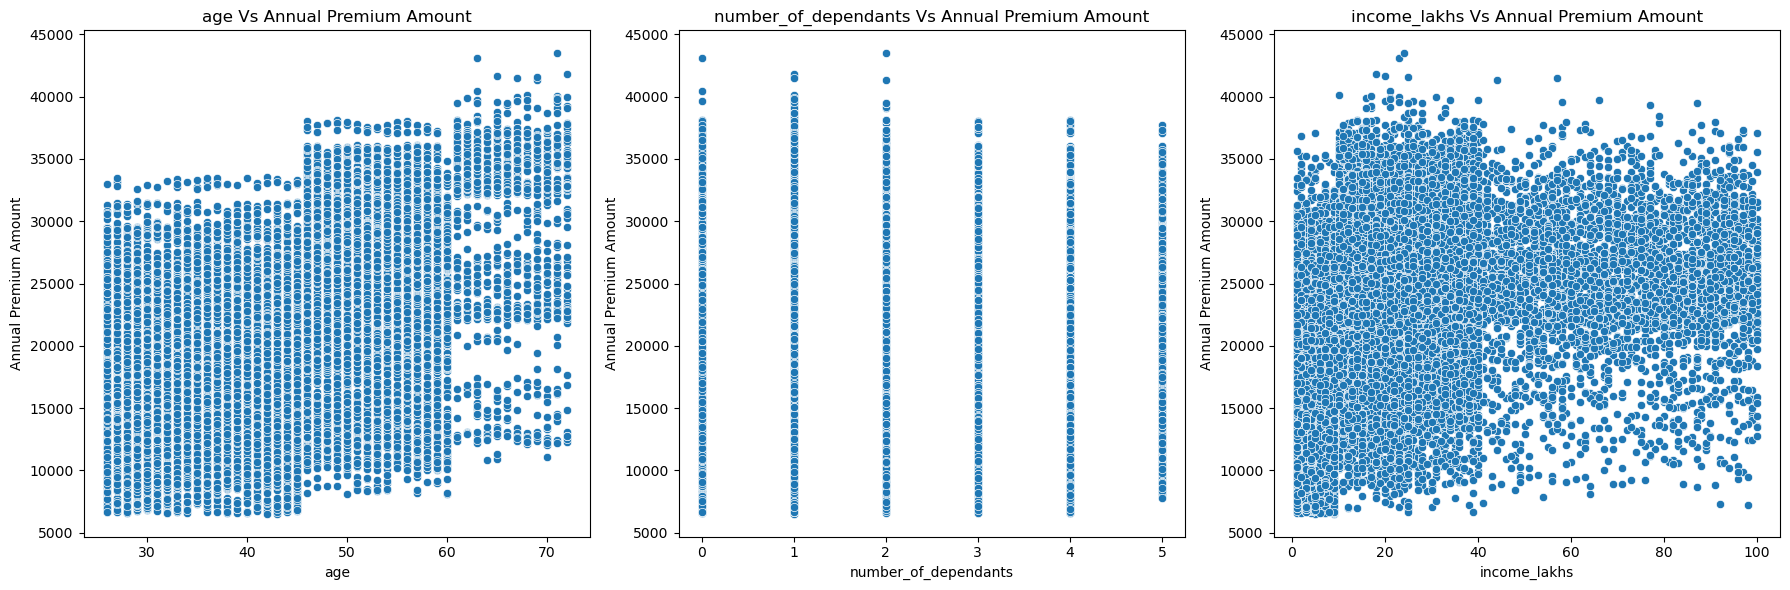

In [39]:
numeric_features=['age', 'number_of_dependants', 'income_lakhs']

fig,axes=plt.subplots(1,len(numeric_features),figsize=(18,6))

for ax,columns in zip(axes,numeric_features):
    sns.scatterplot(x=df_OT1[columns],y=df_OT1['annual_premium_amount'],ax=ax)
    ax.set_title(f'{columns} Vs Annual Premium Amount' )
    ax.set_xlabel(columns)
    ax.set_ylabel('Annual Premium Amount')

plt.tight_layout()
plt.show() 


## 2.Categorical Columns

In [40]:
categorical_columns=df_OT1.select_dtypes(exclude=['number']).columns
categorical_columns

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

In [41]:
for col in categorical_columns:
    print(col,':',df_OT1[col].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Does Not Smoke' 'Not Smoking'
 'Smoking=0']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


In [42]:
df_OT1.smoking_status.replace(
    {
        'Smoking=0':'No Smoking',
        'Does Not Smoke':'No Smoking',
         'Not Smoking':'No Smoking',
    },inplace=True
)

In [43]:
df_OT1.smoking_status.unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

`

### Univariate Analysis

In [44]:
df_OT1.shape

(29822, 14)

In [45]:
df_OT1.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0


In [46]:
pct_count=df_OT1['gender'].value_counts(normalize=True)*100
pct_count.index,pct_count.value_counts,pct_count.values

(Index(['Male', 'Female'], dtype='object'),
 <bound method IndexOpsMixin.value_counts of Male      54.912481
 Female    45.087519
 Name: gender, dtype: float64>,
 array([54.91248072, 45.08751928]))

In [47]:
sns.barplot(x=pct_count.index,y=pct_count.values,ax=ax)

<AxesSubplot:title={'center':'income_lakhs Vs Annual Premium Amount'}, xlabel='income_lakhs', ylabel='Annual Premium Amount'>

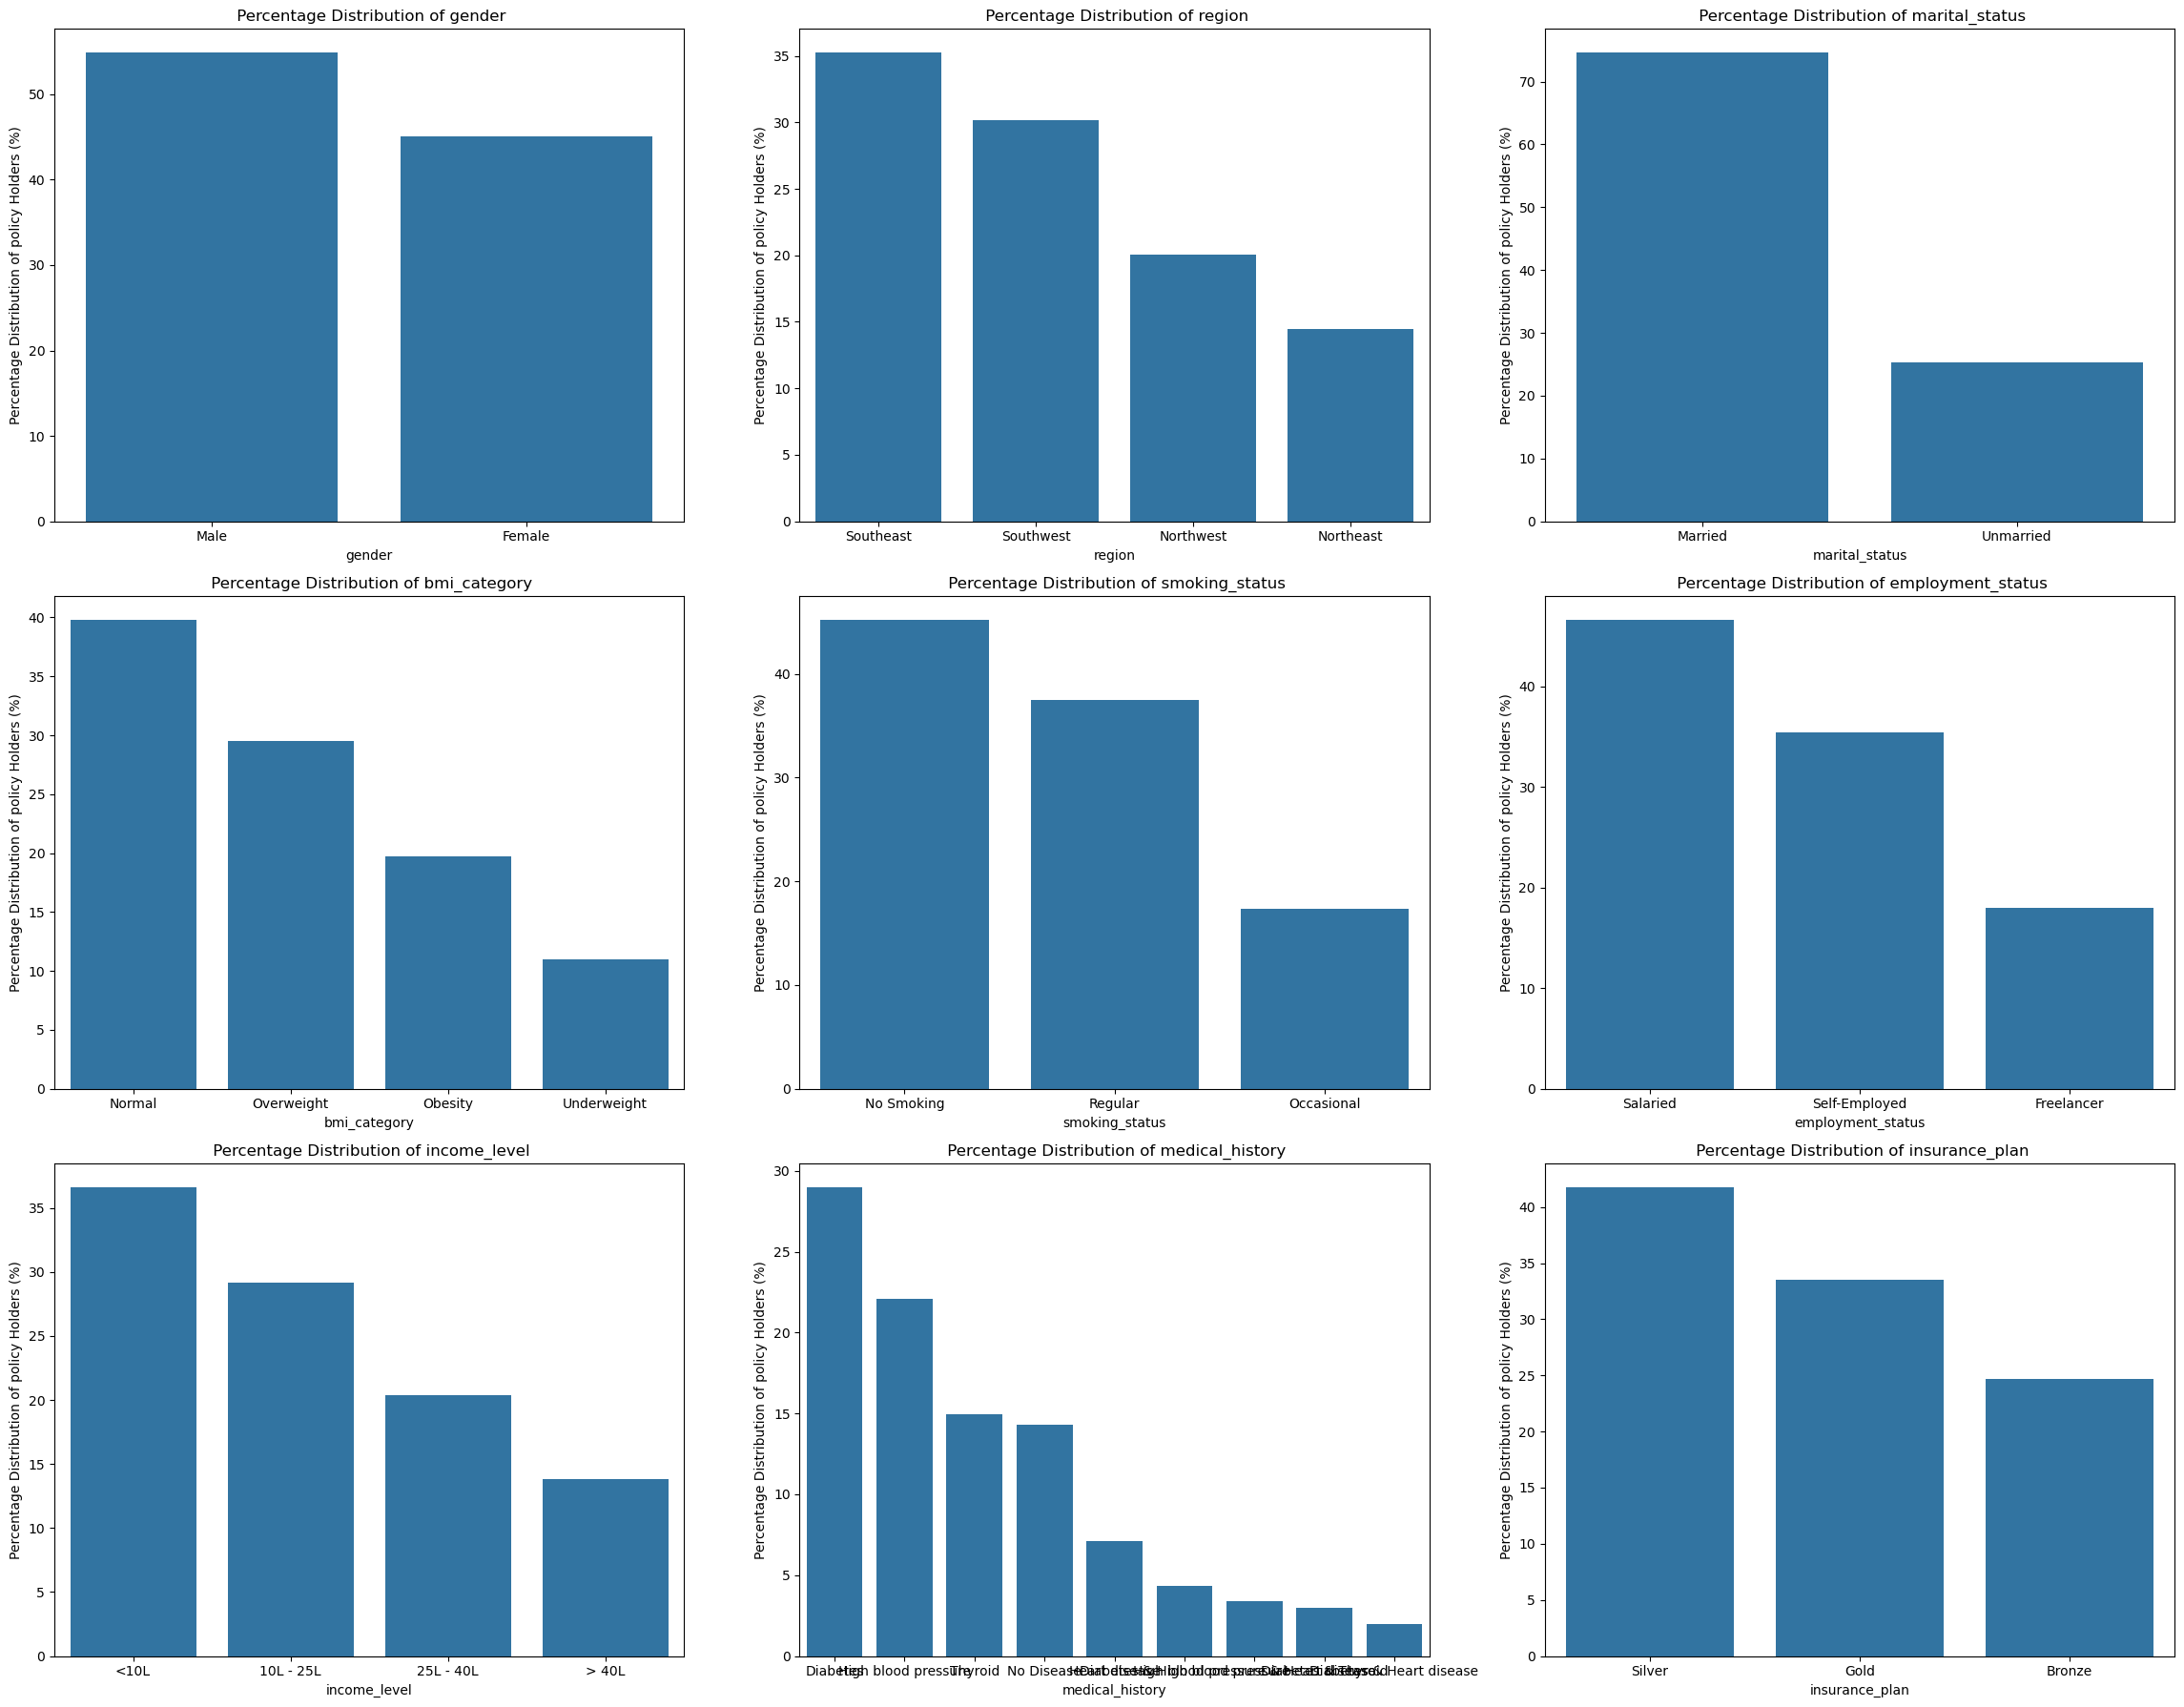

In [48]:
fig,axes=plt.subplots(3,3,figsize=(23,18))
axes=axes.flatten()

for ax,columns in zip(axes,categorical_columns):
    # Calculate the percentage distribution of each category
    categorical_counts=df_OT1[columns].value_counts(normalize=True)*100 # normalize=True gives the relative frequencies
   # Plotting the distribution using barplot
    sns.barplot(x=categorical_counts.index,y=categorical_counts.values,ax=ax)
    ax.set_title(f' Percentage Distribution of {columns}')
    ax.set_ylabel('Percentage Distribution of policy Holders (%)')
    ax.set_xlabel(columns) # Set xlabel to the column name for clarity
    
plt.tight_layout()  # Adjusts plot parameters for better fit in the figure window
plt.show()
   

### Bivariate Analysis

In [49]:
# Cross-tabulation of gender and smoking status
crosstab=pd.crosstab(df_OT1['income_level'],df_OT1['insurance_plan'])
print(crosstab)

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L          799  3554    4354
25L - 40L          301  2631    3142
<10L              6054   527    4341
> 40L              214  3287     618


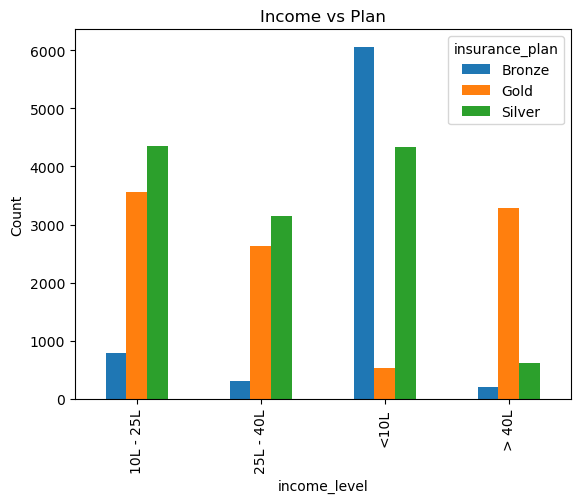

In [50]:
crosstab.plot(kind='bar')
plt.title('Income vs Plan')
plt.ylabel('Count')
plt.show()

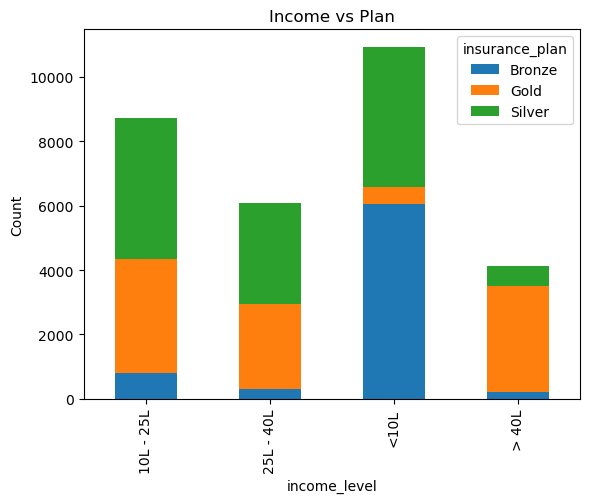

In [51]:
crosstab.plot(kind='bar',stacked=True)
plt.title('Income vs Plan')
plt.ylabel('Count')
plt.show()

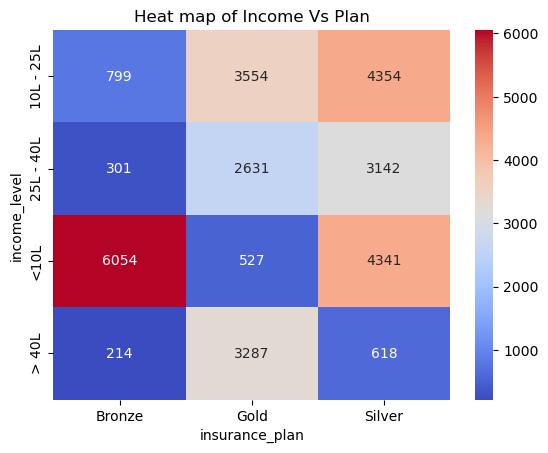

In [52]:
sns.heatmap(crosstab,annot=True,cmap='coolwarm',fmt='d')
plt.title('Heat map of Income Vs Plan')
plt.show()

<h2 align="center" style="color:blue"> Feature Enginnering </h2>

In [53]:
df_OT1.shape

(29822, 14)

In [54]:
df_OT1.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0


In [55]:
df_OT1.medical_history.unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

### Calculate Risk Score

In [56]:
#Business provided risk score numbers for each condition to evalue risk
risk_scores={
     "diabetes": 6,
    "heart disease": 8,
    "high blood pressure":6,
    "thyroid": 5,
    "no disease": 0,
    "none":0
}

df_OT1[['disease1','disease2']]=df_OT1['medical_history'].str.split(" & ",expand=True).apply(lambda x: x.str.lower())
df_OT1['disease1'].fillna('none',inplace=True)
df_OT1['disease2'].fillna('none',inplace=True)
df_OT1['total_risk_score']=0

for disease in ['disease1','disease2']:
    df_OT1['total_risk_score'] += df_OT1[disease].map(risk_scores)

# Normalize the risk score to a range of 0 to 1
max_score=df_OT1['total_risk_score'].max()
min_score=df_OT1['total_risk_score'].min()

df_OT1['normalised_risk_score']=(df_OT1['total_risk_score']-min_score)/(max_score-min_score)


In [57]:
df_OT1.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalised_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0,diabetes,none,6,0.428571


### Encode Text Columns

In [58]:
df_OT1.select_dtypes(exclude=['number']).columns

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan', 'disease1', 'disease2'],
      dtype='object')

In [59]:
df_OT1['insurance_plan'].unique()

array(['Bronze', 'Silver', 'Gold'], dtype=object)

In [60]:
df_OT2=df_OT1.copy()

In [61]:
df_OT2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalised_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0,diabetes,none,6,0.428571


In [62]:
df_OT2['insurance_plan']=df_OT2['insurance_plan'].map({'Bronze':1,'Silver':2,'Gold':3})

In [63]:
df_OT2.income_level.unique()

array(['<10L', '10L - 25L', '> 40L', '25L - 40L'], dtype=object)

In [64]:
df_OT2['income_level']=df_OT2['income_level'].map({'<10L':1,'10L - 25L':2,'25L - 40L':3,'> 40L':4})

In [65]:
cols=['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status']

In [66]:
df_encode=pd.get_dummies(df_OT2,columns=cols,drop_first=True,dtype=int)
df_encode.head(3)

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,0,diabetes,none,...,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,0,diabetes,none,...,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,0,high blood pressure,none,...,0,0,0,0,0,0,0,0,0,1


In [67]:
df_encode.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29822 entries, 0 to 29903
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              29822 non-null  int64  
 1   number_of_dependants             29822 non-null  int64  
 2   income_level                     29822 non-null  int64  
 3   income_lakhs                     29822 non-null  int64  
 4   medical_history                  29822 non-null  object 
 5   insurance_plan                   29822 non-null  int64  
 6   annual_premium_amount            29822 non-null  int64  
 7   genetical_risk                   29822 non-null  int64  
 8   disease1                         29822 non-null  object 
 9   disease2                         29822 non-null  object 
 10  total_risk_score                 29822 non-null  int64  
 11  normalised_risk_score            29822 non-null  float64
 12  gender_Male       

### Feature Selection

In [68]:
df_encode1=df_encode.drop(['medical_history','disease1', 'disease2', 'total_risk_score'], axis=1)
df_encode1.head(2)


,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,normalised_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0


In [69]:
df_encode1.shape

(29822, 20)

### Calculate VIF for Multicolinearity

In [70]:
df_encode1.columns

Index(['age', 'number_of_dependants', 'income_level', 'income_lakhs',
       'insurance_plan', 'annual_premium_amount', 'genetical_risk',
       'normalised_risk_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

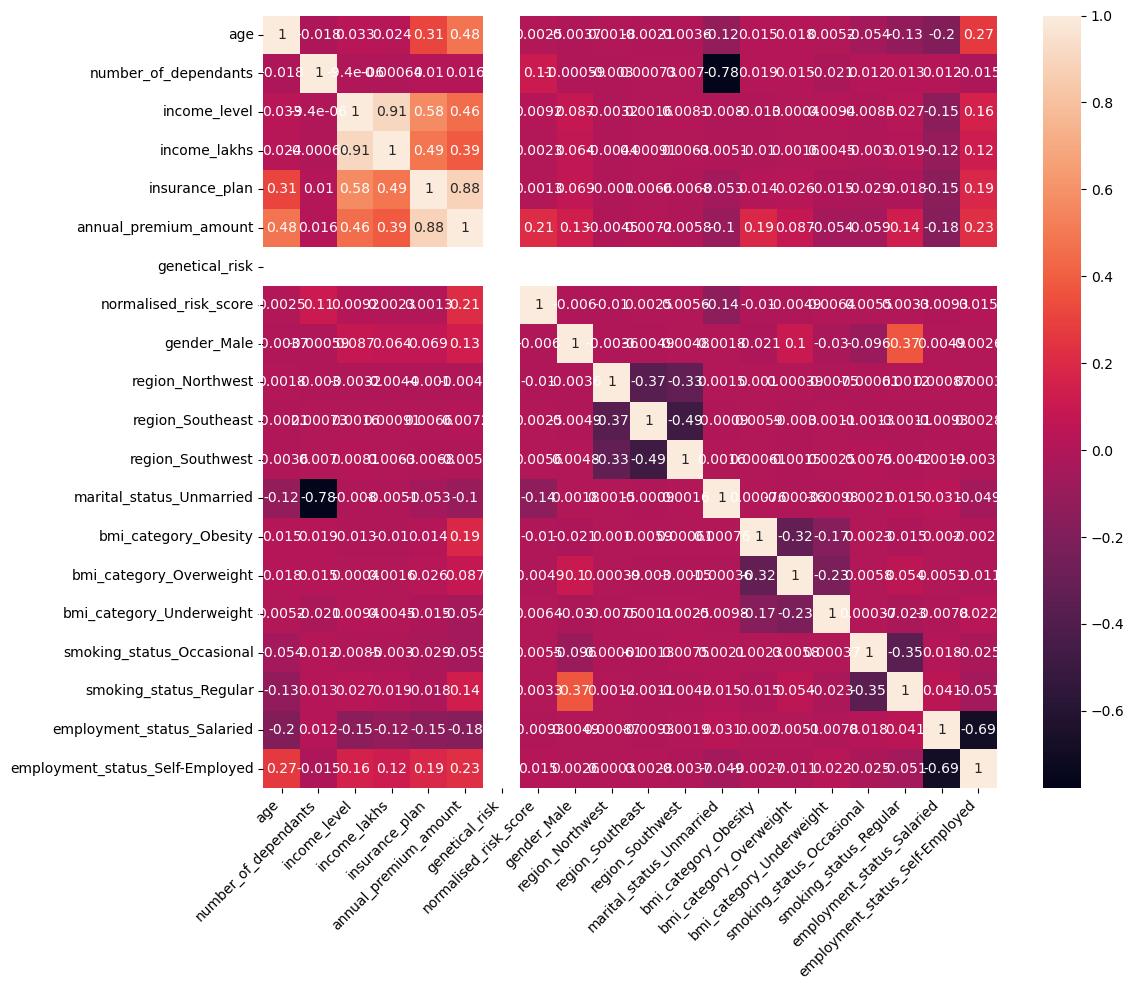

In [71]:
cm=df_encode1.corr()

plt.figure(figsize=(12,10))
sns.heatmap(cm,annot=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [72]:
X=df_encode1.drop('annual_premium_amount',axis='columns')
y=df_encode1['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler

cols_to_scale=['age','number_of_dependants', 'income_level',  'income_lakhs', 'insurance_plan','genetical_risk']
scaler=MinMaxScaler()

X[cols_to_scale]=scaler.fit_transform(X[cols_to_scale])
X.describe()


,age,number_of_dependants,income_level,income_lakhs,insurance_plan,genetical_risk,normalised_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.0,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000
mean,0.371628,0.477547,0.371225,0.224509,0.544112,0.0,0.426373,0.549125,0.200691,0.352693,0.301992,0.253336,0.196835,0.295051,0.110087,0.173228,0.374656,0.466132,0.354269
std,0.240053,0.284129,0.351111,0.226822,0.379009,0.0,0.240084,0.497589,0.400524,0.477816,0.459129,0.434929,0.397613,0.456073,0.313003,0.378450,0.484042,0.498860,0.478299
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.173913,0.200000,0.000000,0.060606,0.500000,0.0,0.357143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.347826,0.600000,0.333333,0.161616,0.500000,0.0,0.428571,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.565217,0.600000,0.666667,0.313131,1.000000,0.0,0.428571,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [73]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [74]:
calculate_vif(X)

E:\Datascince_Projects\env\lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


,Column,VIF
0,age,3.921783
1,number_of_dependants,6.278938
2,income_level,13.890522
3,income_lakhs,11.185596
4,insurance_plan,5.271297
5,genetical_risk,NaN
6,normalised_risk_score,3.810619
7,gender_Male,2.599098
8,region_Northwest,2.123965
9,region_Southeast,2.980842


In [75]:
calculate_vif(X.drop('income_level', axis="columns"))

E:\Datascince_Projects\env\lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


,Column,VIF
0,age,3.863055
1,number_of_dependants,6.278147
2,income_lakhs,2.678102
3,insurance_plan,4.574625
4,genetical_risk,NaN
5,normalised_risk_score,3.808345
6,gender_Male,2.591439
7,region_Northwest,2.123277
8,region_Southeast,2.979899
9,region_Southwest,2.708641


In [76]:
# we will drop income_lakhs due to high VIF value (Generally >10)
X_reduced = X.drop('income_level', axis="columns")

In [77]:
X_reduced.head()

,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,normalised_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.0,0.050505,0.0,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.065217,0.4,0.050505,0.0,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.500000,0.4,0.191919,0.5,0.0,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.086957,0.6,0.767677,1.0,0.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.652174,0.6,0.131313,0.0,0.0,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


<h2 align="center" style="color:blue"> Model Traininmg </h2>

In [78]:
X_reduced.shape

(29822, 18)

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.30, random_state=10)

# shape of the X_train, X_test, y_train, y_test features
print("x train: ",X_train.shape)
print("x test: ",X_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (20875, 18)
x test:  (8947, 18)
y train:  (20875,)
y test:  (8947,)


### Linear Regression Model

In [80]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score = model_lr.score(X_train, y_train)
train_score, test_score

(0.9534163989489616, 0.9538448451629948)

In [81]:
X_test.shape

(8947, 18)

In [82]:
np.set_printoptions(suppress=True, precision=6)
model_lr.coef_

array([ 7016.239328, -1311.764702,  -708.193369, 14835.988208,
           0.      ,  6053.624123,    37.558269,   -55.250872,
         -19.622543,   -22.289676,  -700.3202  ,  3926.812706,
        1979.456047,   612.866236,   837.395101,  2800.661843,
         -45.491367,   243.078421])

In [83]:
feature_importance=model_lr.coef_
X_train.columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'insurance_plan',
       'genetical_risk', 'normalised_risk_score', 'gender_Male',
       'region_Northwest', 'region_Southeast', 'region_Southwest',
       'marital_status_Unmarried', 'bmi_category_Obesity',
       'bmi_category_Overweight', 'bmi_category_Underweight',
       'smoking_status_Occasional', 'smoking_status_Regular',
       'employment_status_Salaried', 'employment_status_Self-Employed'],
      dtype='object')

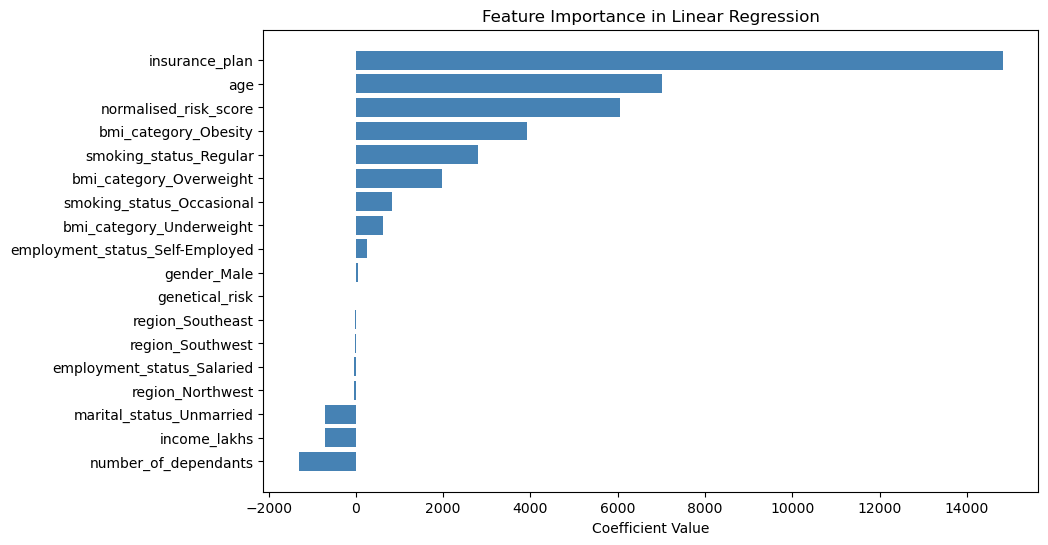

In [84]:
feature_importance=model_lr.coef_

# Create a DataFrame for easier handling
coef_df=pd.DataFrame(feature_importance,index=X_train.columns,columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df=coef_df.sort_values(by='Coefficients',ascending=True)

#Plotting
plt.figure(figsize=(10,6))
plt.barh(coef_df.index,coef_df['Coefficients'],color='Steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

### Ridge Regressin Model

In [85]:
model_ridg=Ridge(alpha=1)
model_ridg.fit(X_train,y_train)
train_score=model_ridg.score(X_train,y_train)
test_score=model_ridg.score(X_test,y_test)
train_score,test_score

(0.9534162332209687, 0.9538456995663842)

### XGBoost

In [86]:
from xgboost import XGBRegressor
model_xgb=XGBRegressor(n_estimators=20, max_depth=3)
model_xgb.fit(X_train,y_train)
train_score=model_xgb.score(X_train,y_train)
test_score=model_xgb.score(X_test,y_test)
train_score,test_score                       

(0.9949295332807941, 0.9948463218448139)

In [87]:
model_xgb=XGBRegressor()
param_grid={
     'n_estimators': [20, 40, 50],
     'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],    
}
random_search=RandomizedSearchCV(model_xgb,param_grid,n_iter=10,cv=3,scoring='r2',random_state=42,n_jobs=-1)
random_search.fit(X_train,y_train)
random_search.best_score_

0.9970577807993951

In [88]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}

In [89]:
best_model=random_search.best_estimator_

### Distribution of Residuals

In [90]:
y_pred=best_model.predict(X_test)

residuals=y_pred-y_test
residuals_pct=(residuals/y_test)* 100

results_df =pd.DataFrame(
    {
        'actual':y_test,
        'predicted':y_pred,
        'diff':residuals,
        'diff_pct':residuals_pct
    }
)

results_df.head()

,actual,predicted,diff,diff_pct
19713,26895,26691.470703,-203.529297,-0.756755
14750,22734,22650.751953,-83.248047,-0.366183
19932,21198,21581.894531,383.894531,1.810994
29643,9100,9425.934570,325.934570,3.581699
17076,26434,26691.470703,257.470703,0.974013


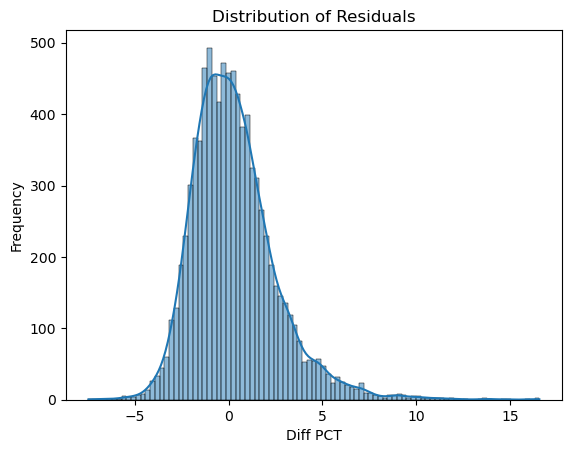

In [91]:
sns.histplot(results_df['diff_pct'],kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Diff PCT')
plt.ylabel('Frequency')
plt.show()

In [92]:
X_test.shape

(8947, 18)

In [93]:
extreme_error_threshold=10 ## this threshold based agrred by business
extreme_results_df =results_df[np.abs(results_df['diff_pct'])>10]
extreme_results_df.shape

(29, 4)

In [94]:
extreme_errors_pct=extreme_results_df.shape[0]*100/X_test.shape[0]
extreme_errors_pct

0.32413099362914943

We have now only 0.3% extreme errors 

### Export The Model

In [95]:
from joblib import dump

dump(best_model, "artifacts/model_rest.joblib")
scaler_with_cols = {
    'scaler': scaler,
    'cols_to_scale': cols_to_scale
}
dump(scaler_with_cols, "artifacts/scaler_rest.joblib")

['artifacts/scaler_rest.joblib']